# Основная модель

In [27]:
from typing import Union

import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from numba import njit

NANOSECOND = 1
MICROSECOND = 1000
MILLISECOND = 1000000
SECOND = 1000000000


def trades_balance(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    return (sells - buys) / (sells + buys + 1e-8)
    
def calc_spreads(lobs, depth,target_data):
    dfs = []
    for i in range(depth):
        bid = lobs[f"bids[{i}].price"]
        ask = lobs[f"asks[{i}].price"]
        dfs.append( (ask - bid).asof(target_data.index,) * target_data.side)
        
    res = pd.concat(dfs, axis=1)
    res.columns = [f"spread_{i}" for i in range(depth)]
    return res
    
def trades_balance(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    return (sells - buys) / (sells + buys + 1e-8)


def calc_imbalance(lobs: pd.DataFrame, lvl_count: int = 20) -> pd.Series:
    """
    Calculate order book imbalance across multiple levels for orderbook_solusdt
    
    Parameters:
    - lobs: DataFrame orderbook_solusdt(lobs) containing order book data (with asks[0-19] and bids[0-19])
    - lvl_count: Number of levels to include in imbalance calculation (default: 20 for all levels)
    
    Returns:
    - Series containing the imbalance calculation
    """
    if lvl_count > 20:
        lvl_count = 20  # Safeguard against requesting more levels than available
    bid_amount = sum(lobs[f"bids[{i}].amount"] for i in range(lvl_count))
    ask_amount = sum(lobs[f"asks[{i}].amount"] for i in range(lvl_count))
    return (bid_amount - ask_amount) / (bid_amount + ask_amount + 1e-8)


def vwap(books_df: pd.DataFrame, lvl_count: int) -> pd.Series:
    """Volume-weighted average price."""
    ask_weighted_price = sum(books_df[f"asks[{i}].price"] * books_df[f"asks[{i}].amount"] for i in range(lvl_count))
    ask_volume = sum(books_df[f"asks[{i}].amount"] for i in range(lvl_count))

    bid_weighted_price = sum(books_df[f"bids[{i}].price"] * books_df[f"bids[{i}].amount"] for i in range(lvl_count))
    bid_volume = sum(books_df[f"bids[{i}].amount"] for i in range(lvl_count))

    total_weighted_price = ask_weighted_price + bid_weighted_price
    total_volume = ask_volume + bid_volume

    vwap = total_weighted_price / total_volume

    return vwap / books_df["mid_price"]


def calculate_atr(data: pd.DataFrame, period: int = 14) -> pd.Series:
    """
    Calculates the Average True Range (ATR) indicator for market candlestick data.

    Parameters:
    - data: A pd.DataFrame with columns ['high', 'low', 'close']
    - period: The period for ATR calculation (default is 14)

    Returns:
    - pd.Series with the calculated ATR
    """
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())

    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period, min_periods=1).mean()

    return atr


    

def calculate_open_interest(data: pd.DataFrame) -> pd.Series:
    open_interest = data['bids[0].amount'] + data['asks[0].amount']
    return open_interest

def calculate_volume(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    volume = trades_df['ask_amount'].rolling(window=window, min_periods=1).sum() + trades_df['bid_amount'].rolling(window=window, min_periods=1).sum()
    return volume

def calculate_large_density(lobs: pd.DataFrame, volume_series: pd.Series) -> pd.Series:
    density = lobs['bids[0].amount'] + lobs['asks[0].amount']
    density, volume = density.align(volume_series, join='outer', fill_value=0)
    large_density = density[density > volume]
    return large_density

def calculate_rsi(data: pd.DataFrame, n: int = 14) -> pd.Series:
    return 100 - (100 / (1 + data.diff(1).mask(data.diff(1) < 0, 0).ewm(alpha=1 / n, adjust=False).mean() / data.diff(1).mask(data.diff(1) > 0, -0.0).abs().ewm(alpha=1 / n, adjust=False).mean()))

def calc_ema(df, n):
    return df.ewm(span = n, adjust = False).mean()


def realized_skew_v2(series):
    series = np.asarray(series)
    skew = np.sum(series**3)
    return np.sign(skew) * np.abs(skew)**(1/3)

def calc_skew_v2(series, window):
    index = series.index
    series = np.asarray(series)
    n = len(series)
    result = np.empty(n)
    result[:] = np.nan
    
    cumsum1 = np.cumsum(series)
    cumsum3 = np.cumsum(series**3)

    for i in range(n):
        start = max(0, i - window + 1)
        sum1 = cumsum1[i] - (cumsum1[start - 1] if start > 0 else 0)
        sum3 = cumsum3[i] - (cumsum3[start - 1] if start > 0 else 0)
        
        skew = np.sign(sum3) * np.abs(sum3)**(1/3)
        result[i] = skew
    result = pd.Series(result)
    result.index = index
    return result

def size_imbalance(lobs):
    bid_amount = 0
    ask_amount = 0
    for i in range(20):
        bid_amount += lobs["bids[" + str(i) + "].amount"]
        ask_amount += lobs["asks[" + str(i) + "].amount"]
    imbalance_size = bid_amount / ask_amount
    return imbalance_size

def trades_count(trades_df: pd.DataFrame, window: Union[str, int]) -> pd.Series:
    sells = trades_df["ask_amount"].rolling(window=window, min_periods=1).sum()
    buys = trades_df["bid_amount"].rolling(window=window, min_periods=1).sum()
    result = (sells + buys)
    return result
    
    

class Predictor:
    def __init__(self, full_model_path: Union[str, list[str]]):
        self.models = []
        for name in full_model_path:
            model = CatBoostClassifier()
            model.load_model(name, format="cbm")
            self.models.append(model)

    @staticmethod
    def model_name() -> Union[str, list[str]]:
        return ["20250108-012907_model_0_plzzzzz.cbm",
                "20250108-013028_model_1_plzzzzz.cbm",
                "20250108-013136_model_2_plzzzzz.cbm", 
                "20250108-013220_model_3_plzzzzz.cbm", 
                "20250108-013326_model_4_plzzzzz.cbm"]

    def predict(self, features: pd.DataFrame) -> pd.Series:
        """
        Method is called once every time new submission received
            Params:
                Your features returned from `calc_features` method

            Returns: pd.Series[float]
                Array of predicted returns (price_{n + 1} / price_{n} - 1).
                One value must be generated for every bbo dataframe timestamp
                so that len(Series) == len(bbos)
        """
        res = np.array([self.models[i].predict_proba(features)[:, 1] for i in range(len(self.models))]).mean(axis = 0)
        return res

    @staticmethod
    def calc_features(
        lobs: pd.DataFrame | None,
        agg_trades: pd.DataFrame | None,
        lobs_embedding: pd.DataFrame | None,
        target_data: pd.DataFrame | None,
    ) -> pd.DataFrame:
        
        target_data_preprocessed = target_data.copy()

        #1 - sol mid_price
        lobs["mid_price"] = (lobs["asks[0].price"] + lobs["bids[0].price"]) / 2
        sol_mid_price = lobs["mid_price"].asof(target_data_preprocessed.index)
        sol_mid_price.name = "sol_mid_price"

        #2 - btc mid price
        btcusdt_mid_price = lobs_embedding[lobs_embedding["instrument"] == "BTCUSDT"]["mid_price"]

        #3 - eth mid price
        ethusdt_mid_price = lobs_embedding[lobs_embedding["instrument"] == "ETHUSDT"]["mid_price"]

        #4 dev price
        main_btcusdt_dev = (lobs["mid_price"] / (btcusdt_mid_price.asof(lobs.index) + 1e-6)).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        main_btcusdt_dev.name = "main_btcusdt_dev"

        main_ethusdt_dev = (lobs["mid_price"] / (ethusdt_mid_price.asof(lobs.index) + 1e-6)).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        main_ethusdt_dev.name = "main_ethusdt_dev"

        main_solusdt_dev = (lobs["mid_price"] / (sol_mid_price.asof(lobs.index) + 1e-6)).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        main_ethusdt_dev.name = "main_solusdt_dev"

        #5 distance to mid_price 
        distance_to_mid_price = (target_data_preprocessed.price / (lobs["mid_price"].asof(target_data_preprocessed.index) + 1e-6) - 1) * target_data_preprocessed.side
        distance_to_mid_price.name = "distance_to_mid_price"

        #6 imbalance 20/10/5
        imbalance_series_lvl_20 = calc_imbalance(lobs).asof(target_data.index) * target_data.side
        imbalance_series_lvl_20.name = "imbalance_lvl_20"

        imbalance_series_lvl_10 = calc_imbalance(lobs, lvl_count=10).asof(target_data.index) * target_data.side
        imbalance_series_lvl_10.name = "imbalance_lvl_10"

        imbalance_series_lvl_5 = calc_imbalance(lobs, lvl_count=5).asof(target_data.index) * target_data.side
        imbalance_series_lvl_5.name = "imbalance_lvl_5"

        #vwap
        depth = 5
        vwap_series = vwap(lobs, depth).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        vwap_series.name = "vwap"
        

        #agg trades 
        solusdt_agg_trades = agg_trades[agg_trades["instrument"] == "SOLUSDT"]


        trades_ratio_series_1m = trades_balance(solusdt_agg_trades, 1 * 60 * SECOND).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        trades_ratio_series_1m.name = "trades_ratio_1m"
        
        trades_ratio_series_5m = trades_balance(solusdt_agg_trades, 5 * 60 * SECOND).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        trades_ratio_series_5m.name = "trades_ratio_5m"
        
        trades_ratio_series_15m = trades_balance(solusdt_agg_trades, 15 * 60 * SECOND).asof(target_data_preprocessed.index) * target_data_preprocessed.side
        trades_ratio_series_15m.name = "trades_ratio_15m"


        

        # Calculate ATR
        lobs["high"] = lobs[["asks[0].price", "bids[0].price"]].max(axis=1)
        lobs["low"] = lobs[["asks[0].price", "bids[0].price"]].min(axis=1)
        lobs["close"] = lobs["mid_price"]
        atr_series = calculate_atr(lobs, period=14).asof(target_data_preprocessed.index)
        atr_series.name = "atr"

        # Calculate Open Interest
        open_interest_series = calculate_open_interest(lobs).asof(target_data_preprocessed.index)
        open_interest_series.name = "open_interest"

        # Calculate Volume
        volume_series_1m = calculate_volume(solusdt_agg_trades, window=1 * 60 * SECOND).asof(target_data.index)
        volume_series_1m.name = "volume_1m"
        
        volume_series_5m = calculate_volume(solusdt_agg_trades, window=5 * 60 * SECOND).asof(target_data.index)
        volume_series_5m.name = "volume_5m"
        
        volume_series_15m = calculate_volume(solusdt_agg_trades, window=15 * 60 * SECOND).asof(target_data.index)
        volume_series_15m.name = "volume_15m"

        # Calculate Large Density
        large_density_series_1m = calculate_large_density(lobs, volume_series_1m).asof(target_data.index)
        large_density_series_1m.name = "large_density_1m"

        large_density_series_5m = calculate_large_density(lobs, volume_series_5m).asof(target_data.index)
        large_density_series_5m.name = "large_density_5m"

        large_density_series_15m = calculate_large_density(lobs, volume_series_15m).asof(target_data.index)
        large_density_series_15m.name = "large_density_15m"

        # Calculate ATR for volume
        #13
        lobs["high_volume"] = lobs[["asks[0].amount", "bids[0].amount"]].max(axis=1)
        lobs["low_volume"] = lobs[["asks[0].amount", "bids[0].amount"]].min(axis=1)
        lobs["close_volume"] = (lobs["asks[0].amount"] + lobs["bids[0].amount"]) / 2
        atr_volume_series = calculate_atr(lobs, period=14).asof(target_data.index)
        atr_volume_series.name = "atr_volume"


        # spread 
        spread_depth = 10
        spread_series = calc_spreads(lobs, spread_depth, target_data).asof(target_data.index)

        # rsi 
        rsi_series_sol = calculate_rsi(lobs["mid_price"], n=14).asof(target_data.index)
        rsi_series_sol.name = 'sol_rsi'

        rsi_series_btc = calculate_rsi(btcusdt_mid_price, n=14).asof(target_data.index)
        rsi_series_btc.name = 'btc_rsi'

        rsi_series_eth = calculate_rsi(ethusdt_mid_price, n=14).asof(target_data.index)
        rsi_series_eth.name = 'eth_rsi'

        #ema
        ema_series_sol_100 = calc_ema(sol_mid_price, n = 100).asof(target_data.index) # 200-тая емашка на 1 часовом тф
        ema_series_sol_100.name = 'sol_ma100'

        ema_series_sol_200 = calc_ema(sol_mid_price, n = 200).asof(target_data.index) # 200-тая емашка на 1 часовом тф
        ema_series_sol_200.name = 'sol_ma200'

        ema_series_sol_10 = calc_ema(sol_mid_price, 10).asof(target_data.index)
        ema_series_sol_10.name = 'sol_ema_10'

        ema_series_sol_20 = calc_ema(sol_mid_price, 20).asof(target_data.index)
        ema_series_sol_20.name = 'sol_ema_20'

        #skew
        skew_5s = calc_skew_v2(sol_mid_price, 5 * SECOND).asof(target_data.index)
        skew_5s.name = 'skew_5s'
        
        skew_10s = calc_skew_v2(sol_mid_price, 10 * SECOND).asof(target_data.index)
        skew_10s.name = 'skew_10s'
        
        skew_15s = calc_skew_v2(sol_mid_price, 15 * SECOND).asof(target_data.index)
        skew_15s.name = 'skew_15s'

        skew_30s = calc_skew_v2(sol_mid_price, 30 * SECOND).asof(target_data.index)
        skew_30s.name = 'skew_30s'
        
        skew_60s = calc_skew_v2(sol_mid_price, 60 * SECOND).asof(target_data.index)
        skew_60s.name = 'skew_60s'

        #new fet
        size_imbalance_series = (
            size_imbalance(lobs).asof(target_data.index) * target_data.side
        )
        size_imbalance_series.name = "size_imbalance"

        momentum_period = 5
        size_imbalance_momentum = size_imbalance_series.pct_change(periods=momentum_period)
        size_imbalance_momentum.name = "size_imbalance_momentum " + str(momentum_period)

        time_lag = 1e-06
        count_sol = trades_count(solusdt_agg_trades, int(time_lag * SECOND)).asof(target_data.index)
        count_sol.name = "count_sol" + str(time_lag)



        df = pd.concat(
            [                   
                target_data_preprocessed.side,
                vwap_series,
                
                trades_ratio_series_1m,
                trades_ratio_series_5m,
                trades_ratio_series_15m,
                
                distance_to_mid_price,
                
                main_ethusdt_dev,
                main_btcusdt_dev,
                
                imbalance_series_lvl_20,
                imbalance_series_lvl_10,
                imbalance_series_lvl_5,
                
                sol_mid_price,
                atr_series,
                open_interest_series,
                
                volume_series_1m,
                volume_series_5m,
                volume_series_15m,
                
                large_density_series_1m,
                large_density_series_5m,
                large_density_series_15m,
                
                atr_volume_series,
                
                rsi_series_sol,
                rsi_series_btc,
                rsi_series_eth,
                
                ema_series_sol_100,
                ema_series_sol_200,
                ema_series_sol_20,
                ema_series_sol_10,

                skew_5s,
                skew_10s,
                skew_15s,
                skew_30s,
                skew_60s,
                
                size_imbalance_momentum,
                count_sol,   
            ],
            axis=1,
        )

        windows = [5, 10,15]

        result = pd.concat({f"window_{window}": df.pct_change(periods=window) for window in windows},axis=1)

        df = pd.concat([df,result], axis = 1)
        return df


# Грузим данные

In [2]:
agg_trades = pd.read_parquet("train/agg_trades.parquet")
lobs_embedding = pd.read_parquet("train/orderbook_embedding.parquet")
lobs = pd.read_parquet("train/orderbook_solusdt.parquet")
target_data = pd.read_parquet("train/target_data_solusdt.parquet")
target = pd.read_parquet("train/target_solusdt.parquet")

In [3]:
%%time
cat_features = ['side']


CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 23.1 µs


In [4]:
%%time
from catboost import CatBoostClassifier


X = Predictor.calc_features(lobs, agg_trades, lobs_embedding, target_data)
y = target['target'] 




CPU times: user 3min 41s, sys: 1min 21s, total: 5min 3s
Wall time: 5min 44s


In [9]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, gap = 10)

In [11]:
from sklearn.model_selection import train_test_split
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.33, shuffle = False)

# Обучаем модель

In [13]:
from sklearn.metrics import log_loss
import gc
from catboost import CatBoostClassifier, Pool 
import lightgbm as lgb


params_research = {
    "use_best_model": True,
    "eval_metric": "Logloss",
    "iterations": 6000,
    "loss_function": "Logloss",
    "l2_leaf_reg": 50,
    "task_type": "CPU",
    "depth": 10,
    "early_stopping_rounds": 50,
    "learning_rate": 0.01,
}

models = []

for fold, (train_index, test_index) in enumerate(tscv.split(X_1)):
    X_train, X_test = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train, y_test = y_1.iloc[train_index], y_1.iloc[test_index]
    model = CatBoostClassifier(**params_research)
    model.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=100)
    models.append(model)
    
        

0:	learn: 0.6926879	test: 0.6928899	best: 0.6928899 (0)	total: 359ms	remaining: 35m 55s
100:	learn: 0.6677691	test: 0.6820786	best: 0.6820786 (100)	total: 24.7s	remaining: 24m 3s
200:	learn: 0.6563856	test: 0.6802763	best: 0.6802351 (196)	total: 49.3s	remaining: 23m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6802263171
bestIteration = 204

Shrink model to first 205 iterations.
0:	learn: 0.6928076	test: 0.6926657	best: 0.6926657 (0)	total: 430ms	remaining: 43m 1s
100:	learn: 0.6749057	test: 0.6699979	best: 0.6699979 (100)	total: 44.5s	remaining: 43m 18s
200:	learn: 0.6672519	test: 0.6639405	best: 0.6639405 (200)	total: 1m 26s	remaining: 41m 41s
300:	learn: 0.6613395	test: 0.6616646	best: 0.6616646 (300)	total: 2m 9s	remaining: 40m 48s
400:	learn: 0.6568154	test: 0.6601841	best: 0.6601841 (400)	total: 2m 51s	remaining: 40m
500:	learn: 0.6529328	test: 0.6592821	best: 0.6592821 (500)	total: 3m 34s	remaining: 39m 17s
600:	learn: 0.6494281	test: 0.6585972	best: 0

#### bestTest = 0.6710531623
#### bestIteration = 581    

In [26]:
for i in range(len(models)):
    models[i].save_model(f"model_{i}_plzzzzz.cbm",format="cbm")

# Feature selection

In [15]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')


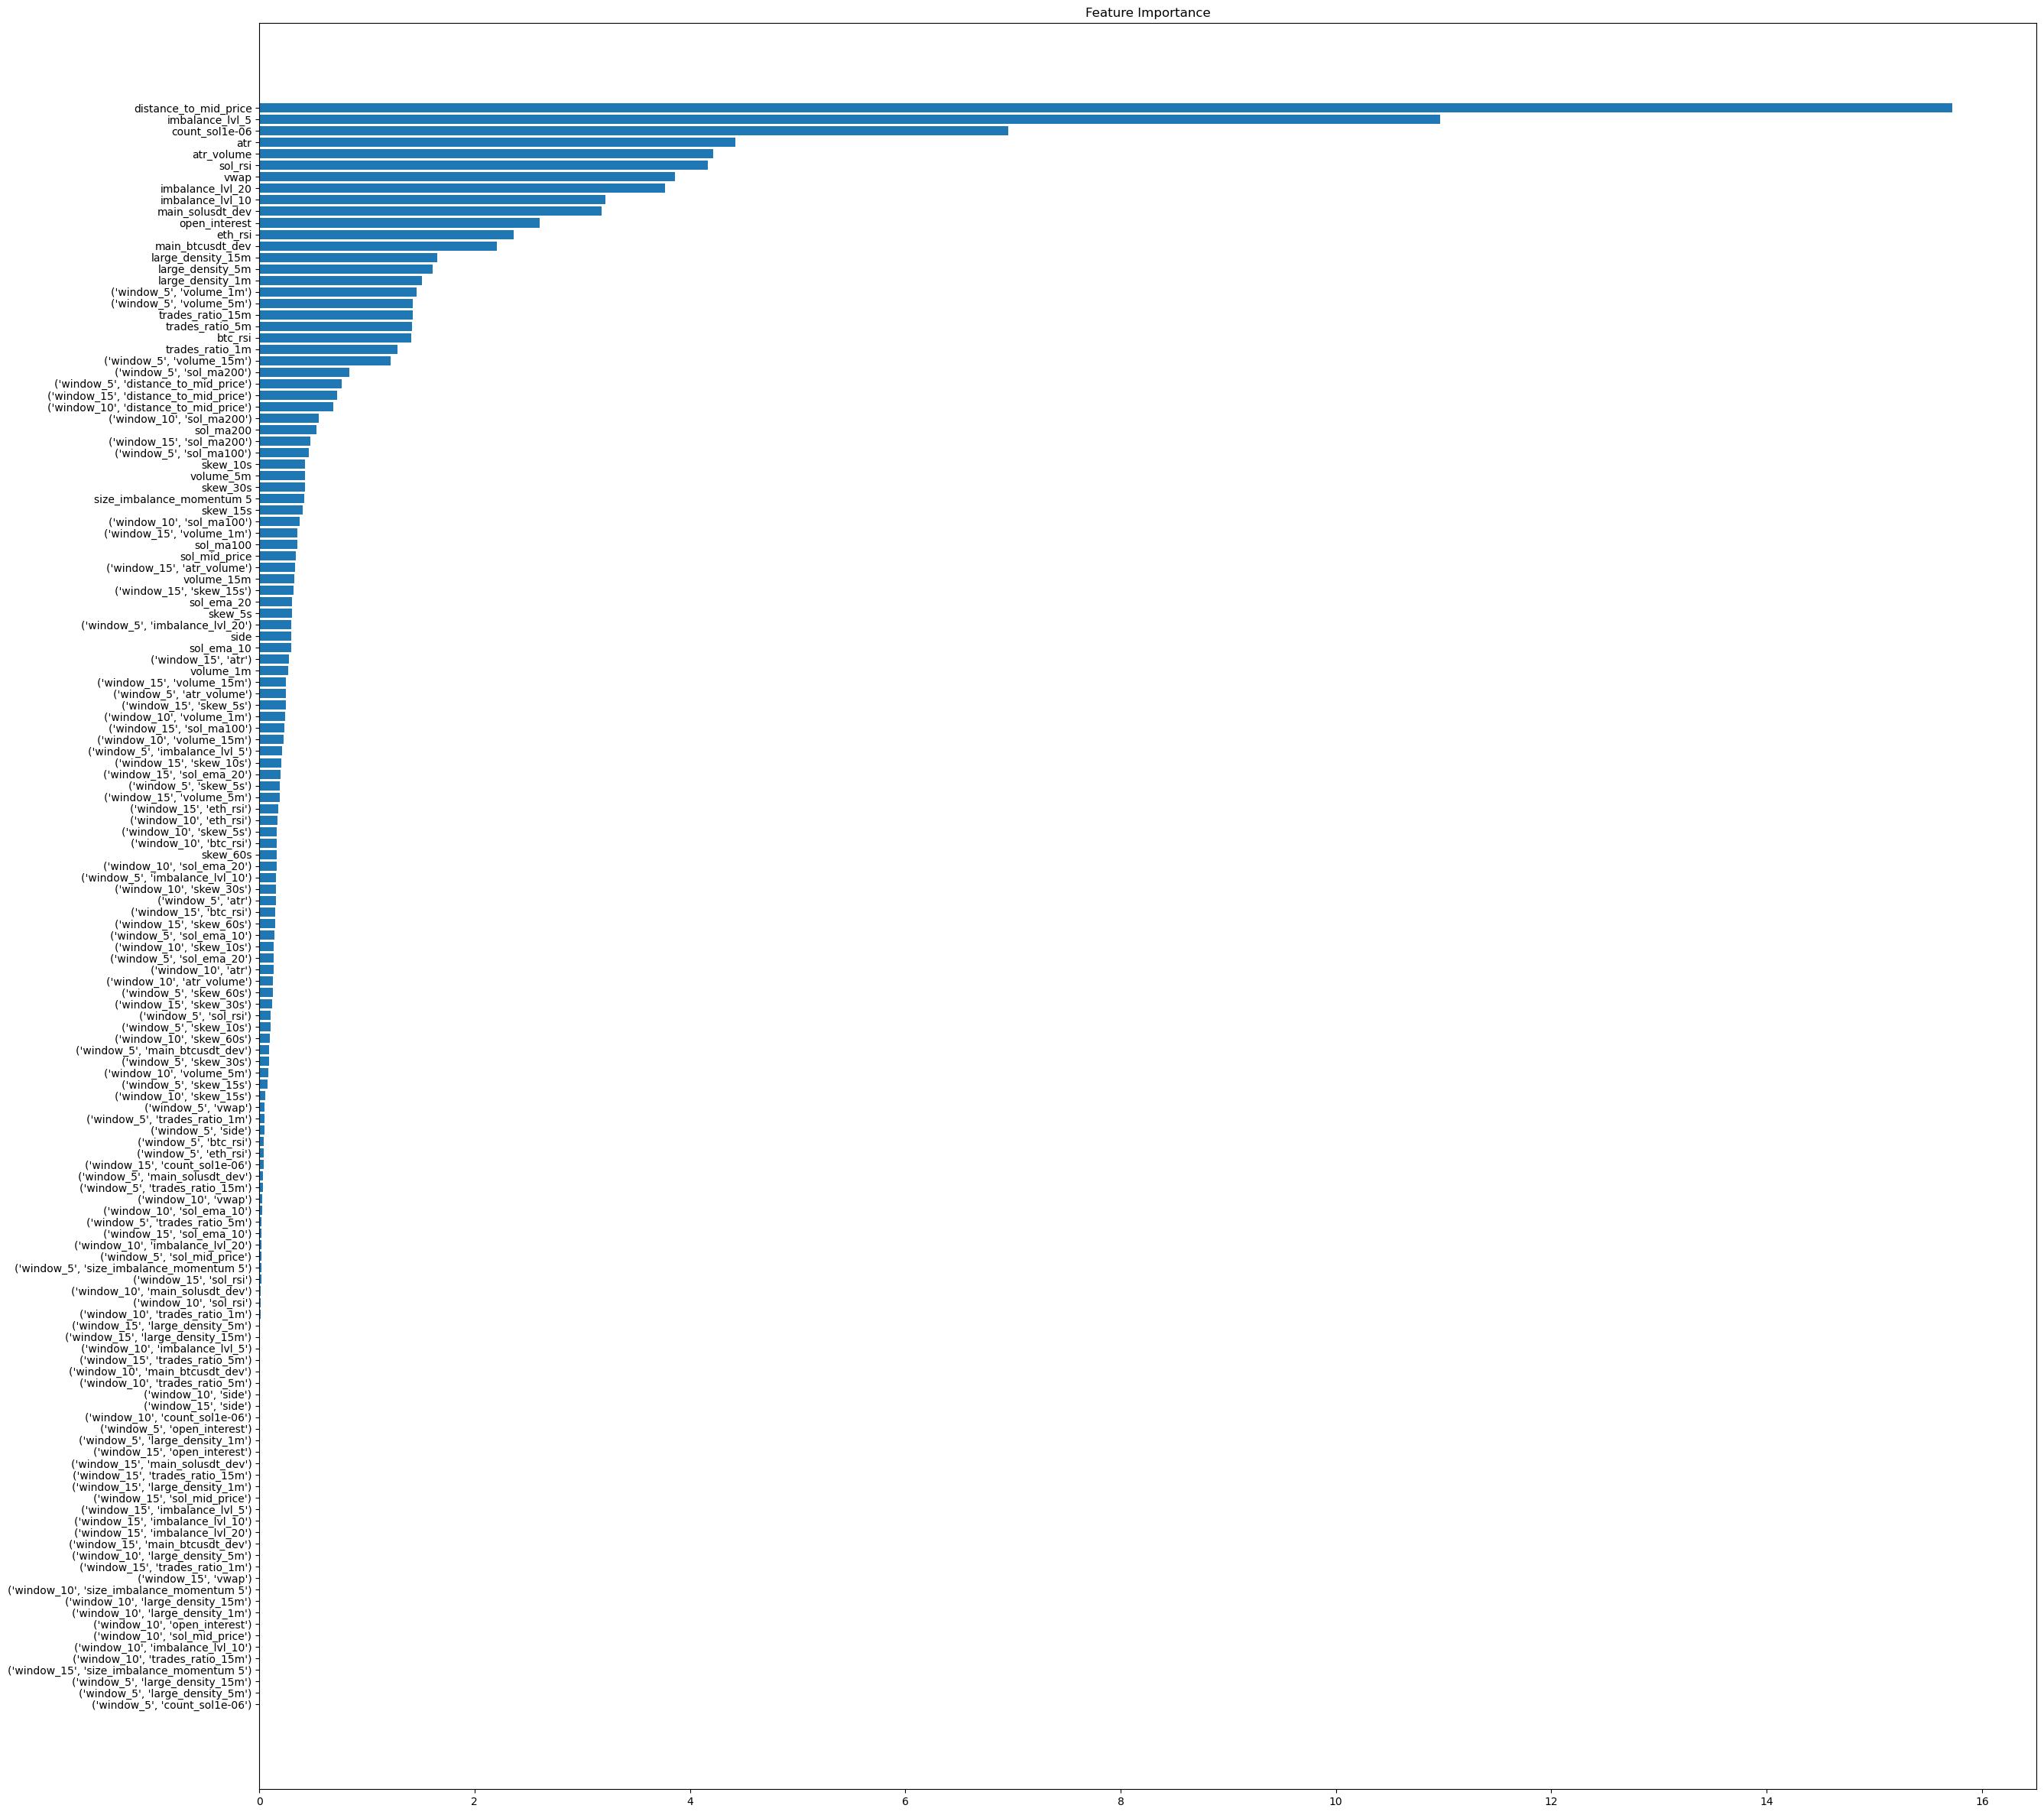

In [11]:
import matplotlib.pyplot as plt


feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(30, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
# lgb.plot_importance(model,figsize = (20,20))
plt.savefig("features.png")

In [30]:
np.array(X.columns)[sorted_idx][:13]

array(['count_sol1e-06_pct5', 'open_interest_pct5',
       'large_density_5m_pct5', 'large_density_15m_pct5',
       'large_density_1m_pct5', 'sol_mid_price_pct5',
       'main_solusdt_dev_pct5', 'vwap_pct5', 'trades_ratio_1m_pct5',
       'trades_ratio_15m_pct5', 'trades_ratio_5m_pct5',
       'main_btcusdt_dev_pct5', 'side_pct5'], dtype=object)

In [12]:
np.array(X.columns)[sorted_idx][50:]

array([('window_5', 'side'), ('window_5', 'trades_ratio_1m'),
       ('window_5', 'vwap'), ('window_10', 'skew_15s'),
       ('window_5', 'skew_15s'), ('window_10', 'volume_5m'),
       ('window_5', 'skew_30s'), ('window_5', 'main_btcusdt_dev'),
       ('window_10', 'skew_60s'), ('window_5', 'skew_10s'),
       ('window_5', 'sol_rsi'), ('window_15', 'skew_30s'),
       ('window_5', 'skew_60s'), ('window_10', 'atr_volume'),
       ('window_10', 'atr'), ('window_5', 'sol_ema_20'),
       ('window_10', 'skew_10s'), ('window_5', 'sol_ema_10'),
       ('window_15', 'skew_60s'), ('window_15', 'btc_rsi'),
       ('window_5', 'atr'), ('window_10', 'skew_30s'),
       ('window_5', 'imbalance_lvl_10'), ('window_10', 'sol_ema_20'),
       'skew_60s', ('window_10', 'btc_rsi'), ('window_10', 'skew_5s'),
       ('window_10', 'eth_rsi'), ('window_15', 'eth_rsi'),
       ('window_15', 'volume_5m'), ('window_5', 'skew_5s'),
       ('window_15', 'sol_ema_20'), ('window_15', 'skew_10s'),
       ('window_

In [13]:
features = np.array(X.columns)[sorted_idx][50:]
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.33, shuffle = False)

In [14]:
params_research = {
    "use_best_model": True,
    "eval_metric": "Logloss",
    "iterations": 6000,
    "loss_function": "Logloss",
    "l2_leaf_reg": 50,
    "task_type": "CPU",
    "depth": 10,
    "early_stopping_rounds": 50,
    "learning_rate": 0.01,
}

model = CatBoostClassifier(**params_research)
model.fit(X_train, y_train, 
        cat_features=[], 
        eval_set=(X_test, y_test), 
        verbose=100,
)



0:	learn: 0.6927901	test: 0.6927797	best: 0.6927797 (0)	total: 1.72s	remaining: 2h 51m 41s
100:	learn: 0.6750304	test: 0.6761470	best: 0.6761470 (100)	total: 2m 23s	remaining: 2h 20m 1s
200:	learn: 0.6692714	test: 0.6725430	best: 0.6725430 (200)	total: 4m 45s	remaining: 2h 17m 4s
300:	learn: 0.6656726	test: 0.6712689	best: 0.6712689 (300)	total: 7m 10s	remaining: 2h 15m 41s
400:	learn: 0.6629667	test: 0.6706942	best: 0.6706942 (400)	total: 9m 38s	remaining: 2h 14m 42s
500:	learn: 0.6607734	test: 0.6703578	best: 0.6703578 (500)	total: 12m 8s	remaining: 2h 13m 17s
600:	learn: 0.6587785	test: 0.6702291	best: 0.6701768 (592)	total: 14m 51s	remaining: 2h 13m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6701767606
bestIteration = 592

Shrink model to first 593 iterations.


In [94]:
features

array(['sol_ma200', 'sol_ema_20', 'sol_ema_10', 'volume_1m', 'sol_ma100',
       'skew_15S', 'skew_60S', 'volume_5m', 'sol_mid_price', 'skew_30S',
       'skew_5S', 'volume_15m', 'skew_10S', 'trades_ratio_1m',
       'trades_ratio_15m', 'main_btcusdt_dev', 'trades_ratio_5m',
       'btc_rsi', 'eth_rsi', 'main_solusdt_dev', 'large_density_15m',
       'imbalance_lvl_10', 'vwap', 'imbalance_lvl_20', 'atr',
       'open_interest', 'atr_volume', 'sol_rsi', 'imbalance_lvl_5',
       'distance_to_mid_price'], dtype=object)

# работа над моделью

In [32]:
params_research = {
    "use_best_model": True,
    "eval_metric": "Logloss",
    "iterations": 6000,
    "loss_function": "Logloss",
    "l2_leaf_reg": 10,
    "task_type": "CPU",
    "depth": 5,
    "early_stopping_rounds": 50,
    "learning_rate": 0.01,
}
model = CatBoostClassifier(**params_research)
model.fit(X_train, y_train, 
        cat_features=[], 
        eval_set=(X_test, y_test), 
        verbose=100,
)

0:	learn: 0.6929041	test: 0.6928967	best: 0.6928967 (0)	total: 300ms	remaining: 30m 1s
100:	learn: 0.6806932	test: 0.6802706	best: 0.6802706 (100)	total: 23s	remaining: 22m 24s
200:	learn: 0.6772811	test: 0.6770255	best: 0.6770255 (200)	total: 45.3s	remaining: 21m 46s
300:	learn: 0.6756287	test: 0.6758059	best: 0.6758059 (300)	total: 1m 6s	remaining: 21m
400:	learn: 0.6743865	test: 0.6751008	best: 0.6751008 (400)	total: 1m 26s	remaining: 20m 13s
500:	learn: 0.6734198	test: 0.6747024	best: 0.6747013 (499)	total: 1m 46s	remaining: 19m 33s
600:	learn: 0.6725668	test: 0.6743312	best: 0.6743312 (600)	total: 2m 6s	remaining: 19m
700:	learn: 0.6718011	test: 0.6740311	best: 0.6740310 (698)	total: 2m 27s	remaining: 18m 34s
800:	learn: 0.6711160	test: 0.6738292	best: 0.6738271 (792)	total: 2m 47s	remaining: 18m 10s
900:	learn: 0.6705202	test: 0.6737081	best: 0.6737079 (897)	total: 3m 9s	remaining: 17m 50s
1000:	learn: 0.6699616	test: 0.6735301	best: 0.6735301 (1000)	total: 3m 29s	remaining: 17m 

In [26]:
model.save_model("model_my_den.cbm",format="cbm")

In [20]:
np.array(X_test.columns)[sorted_idx]

array(['side', 'rsi_signals', 'trades_ratio_5m', 'trades_ratio_15m',
       'main_btcusdt_dev', 'volume_1m', 'trades_ratio_1m', 'volume_15m',
       'sol_mid_price', 'volume_5m', 'main_solusdt_dev',
       'large_density_15m', 'vwap', 'imbalance_lvl_10',
       'imbalance_lvl_20', 'atr', 'atr_volume', 'open_interest', 'rsi',
       'imbalance_lvl_5', 'distance_to_mid_price'], dtype=object)